# Random Forest with engineered features

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

In [117]:
pd.options.display.max_rows = 170 # For debugging, can be removed later
RSEED = 420

## Loading the data from 02_feature_engineering

In [3]:
data_subsets_features = pickle.load(open('data_subsets_features.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
iq_train_train, \
iq_train_test = data_subsets_features

## Wisorizing (seeing the actual test data --> bad idea!)

In [4]:
# def winsorizer(df, colname, clip_upper, time_ratio=0.5):
#     '''
#     Inputs:
#     df: dataframe
#     colname: name of the variable to be winsorised
#     clip_upper: where to clip the values in proportion to the global maximum,
#     e.g. 0.8 => clip the values above 80% of the global maximum of the variable
#     ratio: what portion of the series should be winsorised, 
#     e.g. 0.3 => the first third of the series is modified.
#     Output: the dataframe with one modified variable
#     '''
#     early = df.iloc[:round(df.shape[0]/(1/time_ratio)),:]
#     late = df.iloc[round(df.shape[0]/(1/time_ratio)):,:]
#     clipped_var = early[colname].clip(upper=max(df[colname])*clip_upper)
#     df[colname] = pd.concat([clipped_var, late[colname]])
#     return df

In [5]:
# sj_train_train = winsorizer(sj_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)
# iq_train_train = winsorizer(iq_train_train, 'total_cases', clip_upper=0.8, time_ratio=0.5)

## Adding lags

In [6]:
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [7]:
def get_lagged_dataframe(df, features, max_lag):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags (defined by max_lag) start at 0, which is the original feature (without shift).
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    max_lag: number of maximum lags
    
    """
    d = {}
    for feature in features:
        for lag in range(max_lag+1):
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

In [8]:
sj_train_train_lags = get_lagged_dataframe(sj_train_train, env_cols(sj_train_train), 8)
sj_train_test_lags = get_lagged_dataframe(sj_train_test, env_cols(sj_train_test), 8)

In [9]:
iq_train_train_lags = get_lagged_dataframe(iq_train_train, env_cols(iq_train_train), 8)
iq_train_test_lags = get_lagged_dataframe(iq_train_test, env_cols(iq_train_test), 8)

In [10]:
def join_basics_with_lags(df, df_lags):
    df = df.join(df_lags)
    df = df[df.columns.drop(list(df.filter(regex='lag0')))]
    return df

In [11]:
sj_train_train = join_basics_with_lags(sj_train_train, sj_train_train_lags)
sj_train_test = join_basics_with_lags(sj_train_test, sj_train_test_lags)

In [12]:
iq_train_train = join_basics_with_lags(iq_train_train, iq_train_train_lags)
iq_train_test = join_basics_with_lags(iq_train_test, iq_train_test_lags)

In [13]:
data_subsets_w_lags = [sj_train_train, sj_train_test, iq_train_train, iq_train_test]
# save the data subsets in a pickle
pickle.dump(data_subsets_w_lags, open('train_w_lags.pickle', 'wb'))

## Start here for modelling

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [2]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [3]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

In [4]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [5]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [6]:
sj_train_train, \
sj_train_test, \
iq_train_train, \
iq_train_test = pickle.load(open('train_w_lags.pickle', 'rb'))

## Feature selection

In [477]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(7)
    .index
)

## Preprocessing for Sklearn

In [478]:
def custom_dropper(df, cols):
    '''
    drops rows with NaNs from a dataframe based on their presence in a subset of the df
    '''
    return df[df.index.isin(df[cols].dropna().index)]
# custom_dropper(sj_train_train, my_features)

In [479]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

## Scaling

In [480]:
from sklearn.preprocessing import StandardScaler

In [481]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [482]:
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

## Regression (Random Forest)

In [483]:
from sklearn.ensemble import RandomForestRegressor

In [484]:
from sklearn.model_selection import GridSearchCV

In [440]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 100],
    'max_depth': [1, 3, 10],
#     'max_features': ['auto', 'sqrt', None, 0.5, 0.8, 1],
    'max_leaf_nodes': [7, 10, 15, 20],
#     'bootstrap': [True, False],
    'min_samples_split': [3, 5, 7]
}

# Estimator for use in random search
estimator = RandomForestRegressor(n_jobs = -1)

# Create the random search model
gs = GridSearchCV(estimator, param_grid,
#                   scoring='neg_mean_absolute_error', 
                  cv = 3, 
                  verbose = 1)

# Fit 
gs.fit(X_train, y_train)
gs.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'max_depth': 3,
 'max_leaf_nodes': 20,
 'min_samples_split': 3,
 'n_estimators': 10}

In [441]:
rf = gs.best_estimator_

In [485]:
rf = RandomForestRegressor(max_depth=10)

In [487]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [488]:
y_train_pred = np.exp(rf.predict(X_train))
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

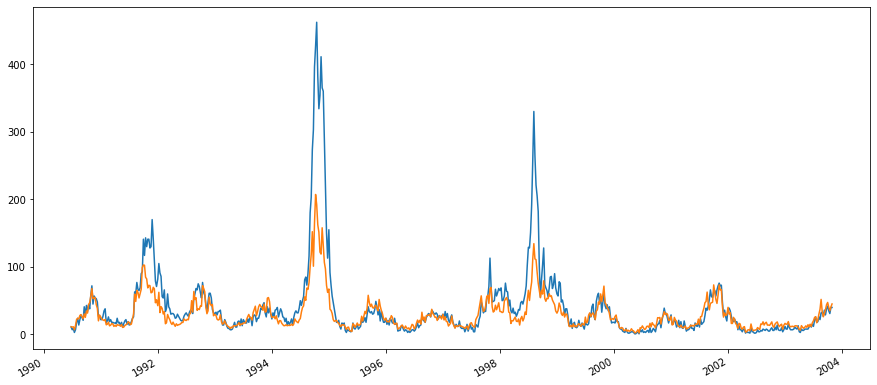

In [489]:
np.exp(y_train).plot()
y_train_pred.plot();

In [490]:
y_test_pred = np.exp(rf.predict(X_test))
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

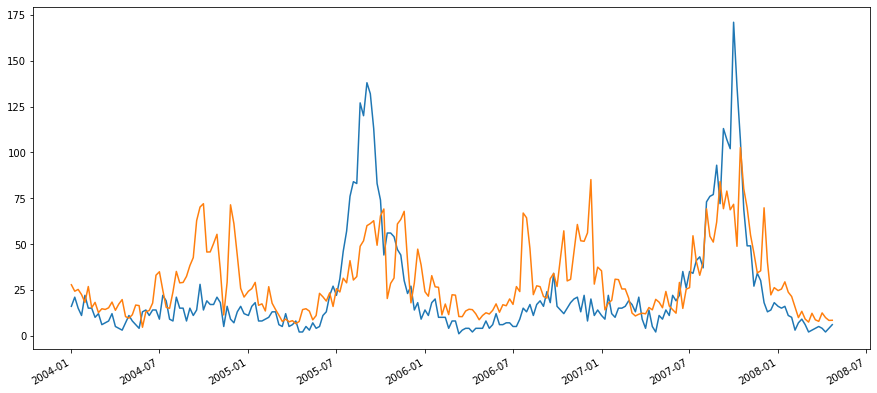

In [491]:
np.exp(y_test).plot()
y_test_pred.plot();

In [492]:
model_classification(np.exp(y_test), y_test_pred)

--------------------
RMSE: 23.72
--------------------
MAE: 16.48
Explained variance: 0.377
--------------------


## Smoothing

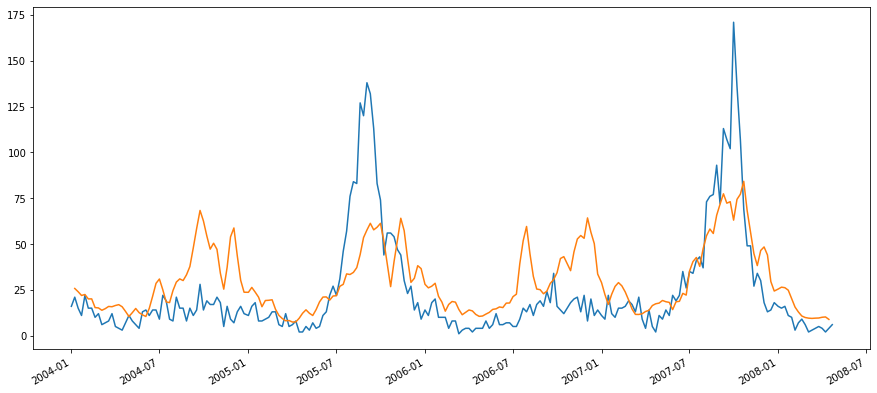

In [493]:
np.exp(y_test).plot()
y_test_pred.rolling(window=3, center=True).mean().plot();

In [494]:
model_classification(np.exp(y_test.iloc[1:-1]), y_test_pred.rolling(window=3, center=True).mean().dropna())

--------------------
RMSE: 22.56
--------------------
MAE: 15.93
Explained variance: 0.444
--------------------


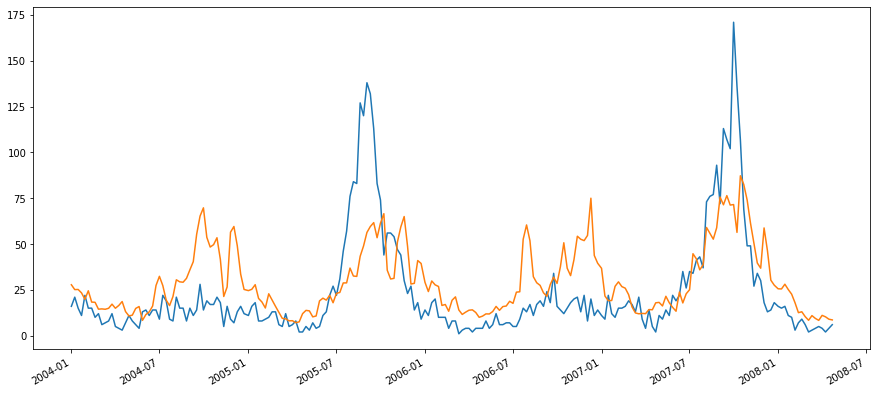

In [506]:
np.exp(y_test).plot()
y_test_pred.ewm(span=2).mean().plot();

In [505]:
model_classification(np.exp(y_test), y_test_pred.ewm(span=2).mean().dropna())

--------------------
RMSE: 23.17
--------------------
MAE: 16.4
Explained variance: 0.408
--------------------


# Poisson Regression

## Feature selection

In [458]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(10)
    .index
)

In [459]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

In [460]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [461]:
from sklearn import linear_model

In [462]:
clf = linear_model.PoissonRegressor(alpha=0.01, max_iter=1000)
clf.fit(X_train, y_train)

PoissonRegressor(alpha=0.01, max_iter=1000)

In [463]:
y_train_pred = clf.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

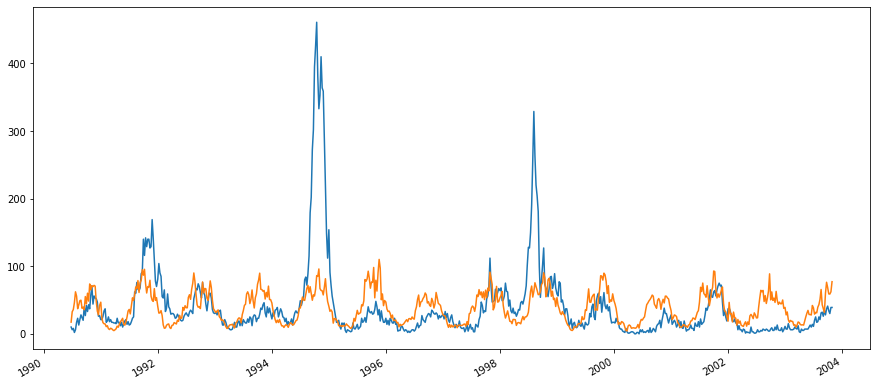

In [464]:
y_train.plot()
y_train_pred.plot();

In [465]:
y_test_pred = clf.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

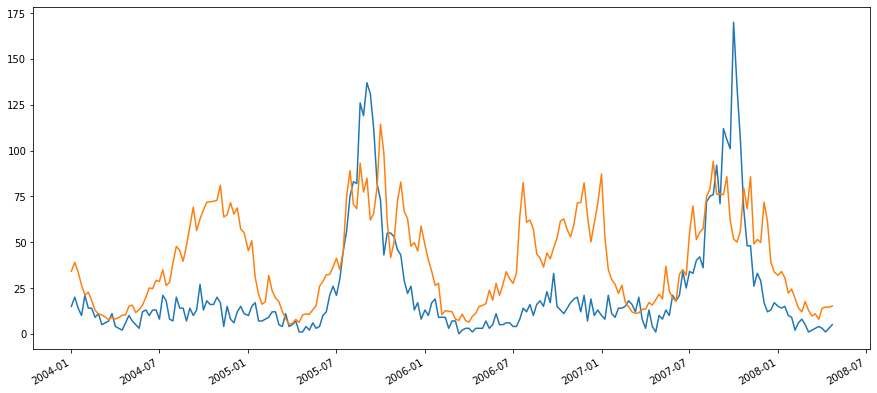

In [466]:
y_test.plot()
y_test_pred.plot();

In [467]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 30.02
--------------------
MAE: 22.73
Explained variance: 0.263
--------------------


# KNN Regression

## Feature selection

In [403]:
corr_mat = sj_train_train.corr()
my_features = (
    corr_mat['total_cases']
    .drop('total_cases')
    .abs()
    .sort_values()
    .tail(10)
    .index
)

In [404]:
X_train = sj_train_train[my_features].dropna()

X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

In [405]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [406]:
from sklearn.neighbors import KNeighborsRegressor

In [413]:
knn = KNeighborsRegressor(n_neighbors=10, p=1)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10, p=1)

In [414]:
y_train_pred = knn.predict(X_train)
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

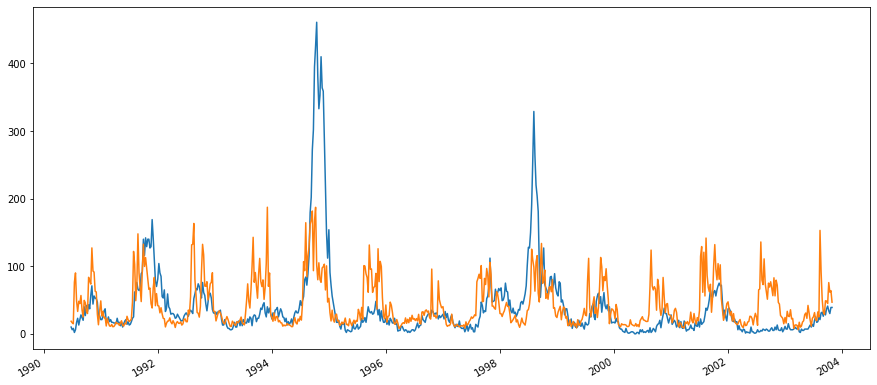

In [415]:
y_train.plot()
y_train_pred.plot();

In [416]:
y_test_pred = knn.predict(X_test)
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

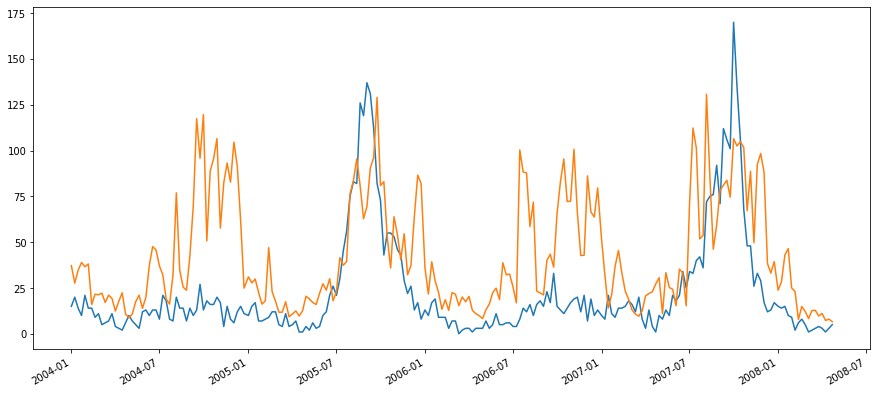

In [417]:
y_test.plot()
y_test_pred.plot();

In [418]:
model_classification(y_test, y_test_pred)

--------------------
RMSE: 34.92
--------------------
MAE: 25.4
Explained variance: 0.049
--------------------


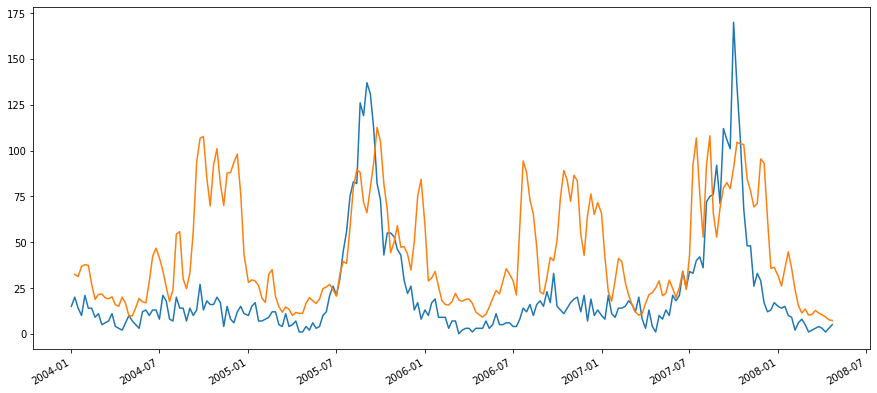

In [419]:
y_test.plot()
y_test_pred.rolling(window=2).mean().plot();

In [428]:
model_classification(y_test.iloc[1:], y_test_pred.rolling(window=2).mean().dropna())

--------------------
RMSE: 33.95
--------------------
MAE: 25.31
Explained variance: 0.135
--------------------


In [21]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [22]:
my_exogs = env_cols(sj_train_train)

In [23]:
prophet_df = pd.DataFrame(sj_train_train.dropna().total_cases).reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = pd.concat([prophet_df, sj_train_train.dropna()[my_exogs].reset_index(drop=True)], axis=1)
# prophet_df['cap'] = 3 * prophet_df['y'].max()
prophet_df.head()

,ds,y,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,...,cum_precip_5w_lag7,cum_precip_5w_lag8,cum_precip_6w_lag1,cum_precip_6w_lag2,cum_precip_6w_lag3,cum_precip_6w_lag4,cum_precip_6w_lag5,cum_precip_6w_lag6,cum_precip_6w_lag7,cum_precip_6w_lag8
0,1990-07-30,17.0,0.170400,0.247150,0.379700,0.381357,34.6,80.584286,32.66,17.594286,...,120.0,98.9,151.8,148.9,175.8,117.9,120.8,141.1,128.6,114.9
1,1990-08-06,23.0,0.180317,0.064333,0.164443,0.138857,20.0,79.650000,28.80,17.950000,...,99.7,120.0,168.3,151.8,148.9,175.8,117.9,120.8,141.1,128.6
2,1990-08-13,13.0,0.185275,0.128033,0.206957,0.168243,101.9,84.178571,90.75,18.515714,...,116.8,99.7,158.6,168.3,151.8,148.9,175.8,117.9,120.8,141.1
3,1990-08-20,21.0,0.190233,0.168800,0.167657,0.172286,25.9,80.947143,32.40,18.174286,...,112.1,116.8,202.2,158.6,168.3,151.8,148.9,175.8,117.9,120.8
4,1990-08-27,28.0,0.252900,0.330750,0.264171,0.284314,39.8,83.348571,40.94,18.515714,...,136.7,112.1,143.9,202.2,158.6,168.3,151.8,148.9,175.8,117.9


In [24]:
m = Prophet(interval_width=0.95,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=0.1,
#             mcmc_samples=1000,
            likelihood='NegBinomial',
            growth='flat',
            yearly_seasonality=True)

In [25]:
m.add_regressor('biting_rate_lag1')
m.add_regressor('biting_rate_lag2')
m.add_regressor('biting_rate_lag3')
m.add_regressor('immature_survival_lag3')
m.add_regressor('transmission_probability_lag2')
m.add_regressor('infection_probability_lag1')
m.add_regressor('cum_precip_3w_lag1')
m.add_regressor('station_diur_temp_rng_k_lag1')
m.add_regressor('reanalysis_dew_point_temp_c_lag2')
m.add_regressor('cum_precip_2w_lag1')
m.add_regressor('fecundity_lag2')
m.add_regressor('mdr_lag2')
m.add_regressor('transmission_probability_lag1')
m.add_regressor('transmission_probability_lag2')
m.add_regressor('transmission_probability_lag3')

In [26]:
for i in range(len(sj_train_train[my_exogs].columns)):
    m.add_regressor(sj_train_train[my_exogs].iloc[:,i].name)

In [27]:
# m.extra_regressors

In [28]:
model = m.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = 83750.9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: neg_binomial_2_lpmf: Location parameter[502] is 0, but must be > 0!  (in 'unknown file name' at line 145)


      99         84068     0.0171437       442.726      0.4982           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       84079.5    0.00616682       69.0535           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       84083.2    0.00425348       141.113      0.4301           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         84086    0.00501457       181.855      0.3929           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       84088.2     0.0193

In [29]:
sj_train = pd.concat([sj_train_train, sj_train_test])
sj_train = sj_train[my_exogs].dropna().reset_index()
sj_train = sj_train.rename(columns={'index': 'ds'})
# sj_train.ds.plot(style='.');

In [30]:
future = m.make_future_dataframe(periods=sj_train_test.shape[0],freq='W')
future =  future.dropna()
# future.plot(style='.');

In [31]:
forecast = m.predict(sj_train)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,biting_rate,biting_rate_lower,biting_rate_upper,biting_rate_lag1,...,transmission_probability_lag8,transmission_probability_lag8_lower,transmission_probability_lag8_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
905,2008-03-25,36.150437,0.0,14.000,36.150437,36.150437,-0.013086,-0.013086,-0.013086,0.028704,...,-0.754085,-0.754085,-0.754085,-0.159394,-0.159394,-0.159394,0.0,0.0,0.0,5.340893
906,2008-04-01,36.150437,2.0,41.025,36.150437,36.150437,-0.005920,-0.005920,-0.005920,0.036749,...,-1.399527,-1.399527,-1.399527,-0.216150,-0.216150,-0.216150,0.0,0.0,0.0,15.143390
907,2008-04-08,36.150437,1.0,34.000,36.150437,36.150437,-0.009868,-0.009868,-0.009868,0.016607,...,-0.902318,-0.902318,-0.902318,-0.199444,-0.199444,-0.199444,0.0,0.0,0.0,12.843938
908,2008-04-15,36.150437,2.0,60.000,36.150437,36.150437,-0.008782,-0.008782,-0.008782,0.027702,...,-0.846555,-0.846555,-0.846555,-0.154257,-0.154257,-0.154257,0.0,0.0,0.0,21.984873
909,2008-04-22,36.150437,0.0,14.000,36.150437,36.150437,-0.002222,-0.002222,-0.002222,0.024652,...,-0.961789,-0.961789,-0.961789,-0.157543,-0.157543,-0.157543,0.0,0.0,0.0,4.775340


This `clips` the possible values, so that there are no negative values (we have count values as the target!!!)

In [32]:
# for col in ['yhat', 'yhat_lower', 'yhat_upper']:
#     forecast[col] = forecast[col].clip(lower=0.0)

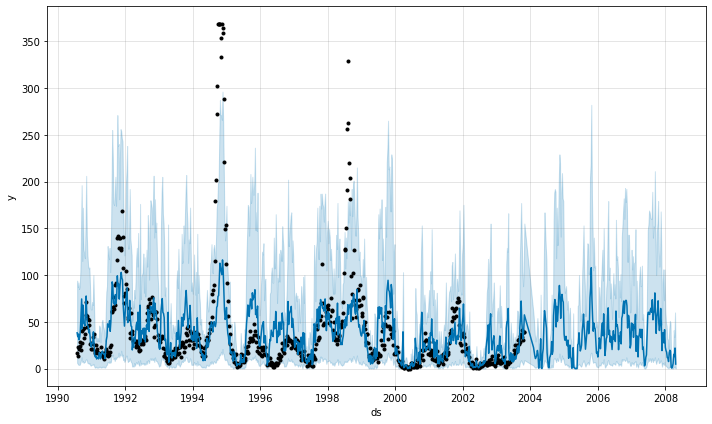

In [33]:
m.plot(forecast);

In [34]:
pred = pd.DataFrame(forecast[['yhat', 'ds']])
pred.index = pred.ds
pred = pred.drop('ds', axis=1)
pred = pred.loc[sj_train_test.index[0]:]

In [35]:
sj_train_test.total_cases.head()

2003-11-05    39
2003-11-12    34
2003-11-19    30
2003-11-26    37
2003-12-03    29
Name: total_cases, dtype: int64

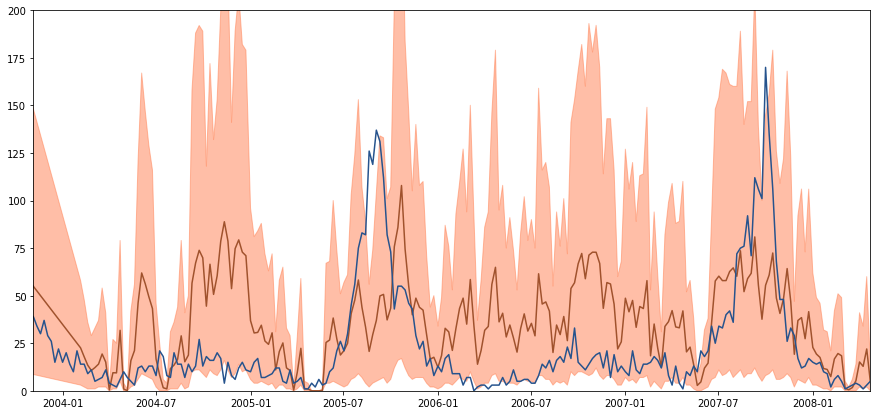

In [36]:
plt.plot(forecast.ds, forecast.yhat, color='sienna')
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, edgecolor='coral', facecolor='coral', alpha=0.5)
plt.plot(sj_train_test.index, sj_train_test.total_cases, color='#26538D')
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

In [37]:
model_classification(sj_train_test.dropna().total_cases, pd.Series(pred.yhat))

--------------------
RMSE: 32.57
--------------------
MAE: 24.59
Explained variance: -0.029
--------------------
